# Gaussian Graphical Model

The non-zero off-diagonal values of $Q$ should be of negative sign, such that the cost ist positive/high if $c_i$ and $c_j$ are of different sign and low if they are of the same sign.

With the non-constant values, $\alpha$ should be negative.

The diagonal values should be the absolute value of the sum of all neighbored off-diagonal elements. In the case of the constant values of $-1$, that is $4$.

## Implementation

In [1]:
import skimage.data
import skimage.filters
import matplotlib.pylab as plt
%matplotlib inline
import numpy as np
import scipy.sparse

In [2]:
def norm_rgb(data):
    for C in range(data.shape[2]):
        data[:, :, C] /= np.max(data[:, :, C])
        data[:, :, C] -= np.min(data[:, :, C])

In [7]:
data = skimage.data.astronaut()
data = skimage.transform.resize(data, (250, 250)).astype('float32')
norm_rgb(data)

def make_noise(data, s=.1):
    noise = np.random.normal(0, scale=s, size=data.size)
    data_noisy = np.clip(data + noise.reshape(data.shape), 0, 1)
    return data_noisy

/home/raphael/proj/uni-ml4cv/env/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [23]:
def make_q_matrix_simple(data, gamma, alpha):
    img_shape = data.shape[0:2]
    n_pixel = data.shape[0] * data.shape[1]
    Q = scipy.sparse.lil_matrix((n_pixel, n_pixel), dtype='float32')
    
    def var_index(x0, x1):
        return x0 * img_shape[1] + x1
    
    for x0 in range(img_shape[0]):
        for x1 in range(img_shape[1]):
            vi0 = var_index(x0, x1)
            # Diagonal element
            Q[vi0, vi0] = 4
            
            # Right neigbor
            if x0 + 1 < img_shape[0]:
                vi1 = var_index(x0 + 1, x1)
                Q[vi0, vi1] = -1.0
                Q[vi1, vi0] = -1.0
                
            # Bottom neigbor
            if x1 + 1 < img_shape[1]:
                vi1 = var_index(x0, x1 + 1)
                Q[vi0, vi1] = -1.0
                Q[vi1, vi0] = -1.0
                
            # Top neigbor
            if x0 > 0:
                vi1 = var_index(x0 - 1, x1)
                Q[vi0, vi1] = -1.0
                Q[vi1, vi0] = -1.0
                
            # Left neigbor
            if x1 > 0:
                vi1 = var_index(x0, x1 - 1)
                Q[vi0, vi1] = -1.0
                Q[vi1, vi0] = -1.0               
    
    return Q

def make_q_matrix_advanced(data, gamma, alpha):
    img_shape = data.shape[0:2]
    n_pixel = data.shape[0] * data.shape[1]
    Q = scipy.sparse.lil_matrix((n_pixel, n_pixel), dtype='float32')
    def var_index(x0, x1):
        return x0 * img_shape[1] + x1
    
    def col2val(c0, c1):
        diff_norm = np.linalg.norm(c0-c1)
        val = np.exp(-gamma * diff_norm)
        return alpha * val
    
    for x0 in range(img_shape[0]):
        for x1 in range(img_shape[1]):
            vi0 = var_index(x0, x1)
            c0 = data[x0, x1]
            
            # right neighbor
            if x0 + 1 < img_shape[0]:
                vi1 = var_index(x0 + 1, x1)
                c1 = data[x0 + 1, x1]
                Q[vi0, vi1] = Q[vi0, vi1] = col2val(c0, c1)
                
            # Bottom neigbor
            if x1 + 1 < img_shape[1]:
                vi1 = var_index(x0, x1 + 1)
                c1 = data[x0, x1 + 1]
                Q[vi0, vi1] = Q[vi0, vi1] = col2val(c0, c1)
                
            # Top neigbor
            if x0 > 0:
                vi1 = var_index(x0 - 1, x1)
                Q[vi0, vi1] = -1.0
                Q[vi1, vi0] = -1.0
                c1 = data[x0 - 1, x1]
                Q[vi0, vi1] = Q[vi0, vi1] = col2val(c0, c1)
                
            # Left neigbor
            if x1 > 0:
                vi1 = var_index(x0, x1 - 1)
                Q[vi0, vi1] = -1.0
                Q[vi1, vi0] = -1.0  
                c1 = data[x0, x1 - 1]
                Q[vi0, vi1] = Q[vi0, vi1] = col2val(c0, c1)   
               
    for x0 in range(img_shape[0]):
        for x1 in range(img_shape[1]):
            vi0 = var_index(x0, x1)
            s = 0
            if x0 + 1 < img_shape[0]:
                s += Q[vi0, var_index(x0+1, x1)]
            if x1 + 1 < img_shape[1]:
                s += Q[vi0, var_index(x0, x1+1)]
            if x0 > 0:
                s += Q[vi0, var_index(x0-1, x1)]
            if x1 > 0:
                s += Q[vi0, var_index(x0, x1-1)]
                
            Q[vi0, vi0] = np.abs(s)
    return Q

def optimize(mu, Q, sigma):
    A = scipy.sparse.identity(Q.shape[0]) + sigma ** 2 * Q
    x = scipy.sparse.linalg.spsolve(A=A, b=mu)
    return x

def experiment(data_noisy, alpha=-1, gamma=10.1, sigma=1., fun=make_q_matrix_advanced):
    # Sigma: How much to trust the observerions (more sigma, less smoothing)
    Q = fun(data_noisy, gamma=gamma, alpha=alpha)
    result = np.copy(data_noisy)
    for c in range(data_noisy.shape[2]):
        result[:, :, c] = optimize(mu=data_noisy[:, :, c].ravel(), Q=Q, sigma=sigma).reshape(data_noisy.shape[0:2])
    norm_rgb(result)
    return result

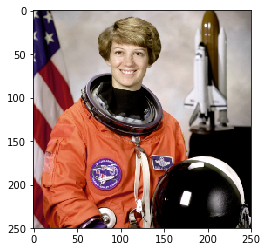

In [9]:
plt.imshow(data)

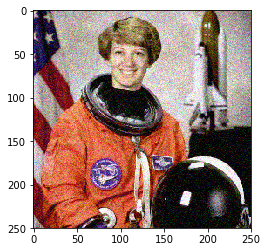

In [10]:
data_noisy = make_noise(data, .1)
plt.imshow(data_noisy)

   ## Simple vs. exponential off-diagonal values

/home/raphael/proj/uni-ml4cv/env/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


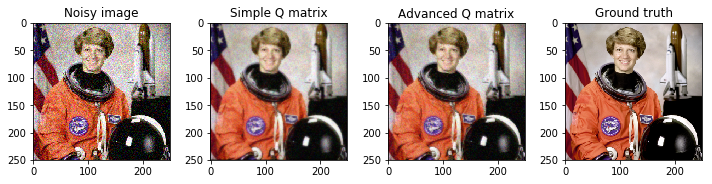

In [13]:
result_simple = experiment(data_noisy, fun=make_q_matrix_simple)
result_advanced = experiment(data_noisy, fun=make_q_matrix_advanced)

fig, axs = plt.subplots(1, 4, figsize=(10, 5))
axs[0].imshow(data_noisy)
axs[0].set_title('Noisy image')
axs[1].imshow(result_simple)
axs[1].set_title('Simple Q matrix')
axs[2].imshow(result_advanced)
axs[2].set_title('Advanced Q matrix')
axs[3].imshow(data)
axs[3].set_title('Ground truth')
fig.tight_layout()
fig.show()

The simple Q matrix leads to a result that basically looks like Gaussian blurring, while with the advanced Q matrix, edges are better retained.

## Different noise levels $s$

Noise level: 0.01, Sum of squared error: 616.6914402561705
Noise level: 0.05, Sum of squared error: 745.1831479280739
Noise level: 0.1, Sum of squared error: 1018.6534486060536


/home/raphael/proj/uni-ml4cv/env/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


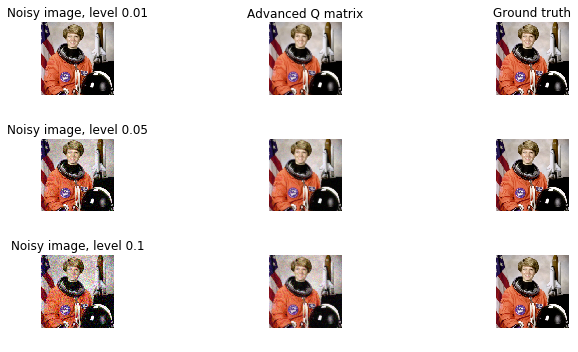

In [31]:
s_ = (.01, .05, .1)
fig, axs = plt.subplots(len(s_), 3, figsize=(10, 5))
axs[0, 0].set_title('Noisy image')
axs[0, 1].set_title('Advanced Q matrix')
axs[0, 2].set_title('Ground truth')
for i, s in enumerate(s_):
    data_noisy = make_noise(data, s)
    result_advanced = experiment(data_noisy, fun=make_q_matrix_advanced)
    print("Noise level: {}, Sum of squared error: {}".format(
        s,
        np.sum((result_advanced - data) ** 2)
    ))
    axs[i, 0].set_title("Noisy image, level {}".format(s))
    axs[i, 0].imshow(data_noisy)
    axs[i, 1].imshow(result_advanced)
    axs[i, 2].imshow(data)
    for x in axs[i]:
        x.axis('off')

fig.tight_layout()
fig.show()

## Different $\alpha$ values

Alpha: -0.01, Sum of squared error: 1104.208429853545
Alpha: -0.1, Sum of squared error: 1095.7630379111424
Alpha: -1, Sum of squared error: 1019.1974658642641
Alpha: -10, Sum of squared error: 654.9968510776486


/home/raphael/proj/uni-ml4cv/env/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


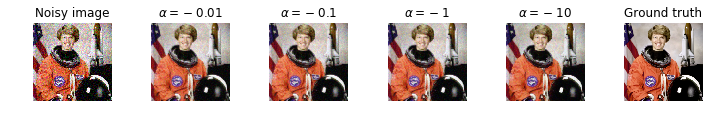

In [27]:
alphas = (-.01, -.1, -1, -10)
data_noisy = make_noise(data, s=.1)
fig, axs = plt.subplots(1, len(alphas) + 2, figsize=(10, 5))
for i, alpha in enumerate(alphas):
    result_advanced = experiment(data_noisy, fun=make_q_matrix_advanced,
                                 alpha=alpha)
    print("Alpha: {}, Sum of squared error: {}".format(
        alpha,
        np.sum((result_advanced - data) ** 2)
    ))
    axs[i + 1].imshow(result_advanced)
    axs[i + 1].set_title(r"$\alpha = {}$".format(alpha))

for x in axs:
    x.axis('off')
axs[0].imshow(data_noisy)
axs[-1].imshow(data)
axs[0].set_title('Noisy image')
axs[-1].set_title('Ground truth')
fig.tight_layout()
fig.show()

## Different $\gamma$ values

Gamma: 0.1, Sum of squared error: 693.5202669296342
Gamma: 1, Sum of squared error: 682.8082897900254
Gamma: 5, Sum of squared error: 903.9490848257216
Gamma: 10, Sum of squared error: 1026.5042784712807
Gamma: 25, Sum of squared error: 1096.6418896404887


/home/raphael/proj/uni-ml4cv/env/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


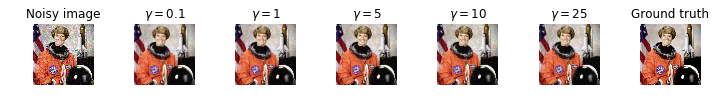

In [32]:
gammas = (.1, 1, 5, 10, 25)
data_noisy = make_noise(data, s=.1)
fig, axs = plt.subplots(1, len(gammas) + 2, figsize=(10, 5))
for i, gamma in enumerate(gammas):
    result_advanced = experiment(data_noisy, fun=make_q_matrix_advanced,
                                 gamma=gamma)
    print("Gamma: {}, Sum of squared error: {}".format(
        gamma,
        np.sum((result_advanced - data) ** 2)
    ))
    axs[i + 1].imshow(result_advanced)
    axs[i + 1].set_title(r"$\gamma = {}$".format(gamma))

for x in axs:
    x.axis('off')
axs[0].imshow(data_noisy)
axs[-1].imshow(data)
axs[0].set_title('Noisy image')
axs[-1].set_title('Ground truth')
fig.tight_layout()
fig.show()

## Different $\sigma$ values

Sigma: 0.01, Sum of squared error: 1599.5491282242813
Sigma: 0.1, Sum of squared error: 1537.463806624807
Sigma: 1, Sum of squared error: 1021.2623225795844
Sigma: 5, Sum of squared error: 9558.177945988185
Sigma: 10, Sum of squared error: 14245.675828624926
Sigma: 100, Sum of squared error: 29891.80930380664


/home/raphael/proj/uni-ml4cv/env/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


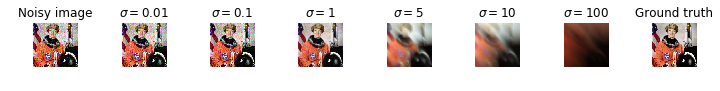

In [33]:
sigmas = (.01, .1, 1, 5, 10, 100)
data_noisy = make_noise(data, s=.1)
fig, axs = plt.subplots(1, len(sigmas) + 2, figsize=(10, 5))
for i, sigma in enumerate(sigmas):
    result_advanced = experiment(data_noisy, fun=make_q_matrix_advanced,
                                 sigma=sigma)
    print("Sigma: {}, Sum of squared error: {}".format(
        sigma,
        np.sum((result_advanced - data) ** 2)
    ))
    axs[i + 1].imshow(result_advanced)
    axs[i + 1].set_title(r"$\sigma = {}$".format(sigma))

for x in axs:
    x.axis('off')
axs[0].imshow(data_noisy)
axs[-1].imshow(data)
axs[0].set_title('Noisy image')
axs[-1].set_title('Ground truth')
fig.tight_layout()
fig.show()